# **AML Project : Raman Spectroscopy**

## Import libraries

In [1]:
import os, glob, re
#Needed if Google Colab is used
#from google.colab import drive
from sklearn.datasets import load_files

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from statistics import mean

from sklearn import decomposition, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import random

## Extract data

In [2]:
#Load data from google colab:
#drive.mount('/content/drive', force_remount=True)
#root_dir = "/content/drive/My Drive/"
#base_dir = root_dir + 'Raman_Data/'

#Load data from directory:
os.chdir(os.getcwd())
base_dir = 'Raman_Data/'
als_dir = base_dir + 'ALS/'
ctrl_dir = base_dir + 'CTRL/'

### Get als and ctrl files from directories

In [3]:
all_files_als = os.listdir(als_dir)
print(len(all_files_als))
all_files_ctrl = os.listdir(ctrl_dir)
print(len(all_files_ctrl))

393
198


### Sort the files by ascending order

In [4]:
all_files_als.sort(key=lambda f: int(re.sub('\D', '', f)))
all_files_ctrl.sort(key=lambda f: int(re.sub('\D', '', f)))

In [5]:
#print(all_files_als[226]) -> 227 missing

## Utility function to parse files


In [6]:
def parse_text(file, dir):
  with open(dir + file, 'rt') as fd:
    data=[]
    line = fd.readline()
    nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    data.append(nline)
    while line:
      line=fd.readline()
      nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
      data.append(nline)
  return data

## Create X and Y 



*   **X** corresponds to the y coordinates of the spectra
*   **Y** corresponds to the class of the spectra ie 0 -> CTRL and 1 -> ALS
*   **coord** corresponds to the x coordinates of the spectra (in order to plot some of them later on)
*   **groups** contains the corresponding index of the patients' spectra ie patient1 -> 0, patient2 -> 1 ... patient30 -> 29.
*   **sep** is a list with the last spectrum number (cumulated)




In [7]:
X=[] #actual y of spectra
Y=[] # 1 -> als; 0 -> ctrl
coord=[] #actual x of spectra

sep=[60,78,114,150,194,210,225,241,255,280,299,313,323,333,343,353,363,373,383,393] #Il manque le 227
groups=[] #for GROUP K FOLD
group=0
index=1
for f in all_files_als:
  data=[]
  datab=[]
  for e in parse_text(f, als_dir):
    if len(e) > 0:
      datab.append(float(e[0]))
      data.append(float(e[1]))
  coord.append(datab)
  X.append(data)
  Y.append(1)
  groups.append(group)
  if index in sep:
    group+=1
  index+=1

In [8]:
#print(len(X))
sep=[33,76,91,138,149,158,168,178,188,198]
index=1
for f in all_files_ctrl:
  data=[]
  datab=[]
  for e in parse_text(f, ctrl_dir):
    if len(e) > 0:
      datab.append(float(e[0]))
      data.append(float(e[1]))
  coord.append(datab)
  X.append(data)
  Y.append(0)
  groups.append(group)
  if index in sep:
    group+=1
  index+=1

### Transform data in np array for preprocessing

In [9]:
X=np.array(X)
Y=np.array(Y)
groups=np.array(groups)
print(X.shape, Y.shape)

(591, 1174) (591,)


## Plot spectra

Plotting some spectra in order to have a look

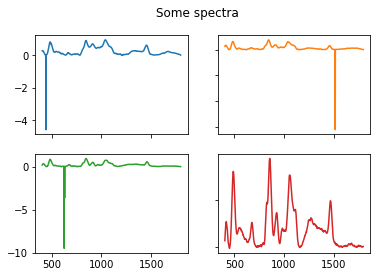

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(coord[5], X[5])
ax2.plot(coord[80], X[80], 'tab:orange')
ax3.plot(coord[78], X[78], 'tab:green')
ax4.plot(coord[500], X[500], 'tab:red')


for ax in fig.get_axes():
    ax.label_outer()

## Remove negative values from spectra

In [11]:
for i in range(len(X)):
    for j in range (len(X[i])):
        if(X[i][j] < 0):
            X[i][j] = 0

### Plot again

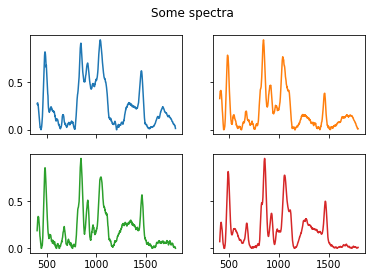

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(coord[5], X[5])
ax2.plot(coord[80], X[80], 'tab:orange')
ax3.plot(coord[78], X[78], 'tab:green')
ax4.plot(coord[500], X[500], 'tab:red')


for ax in fig.get_axes():
    ax.label_outer()

## Feature Extraction With PCA

### Strandardize features

In [13]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X)

### PCA in action

**n_component** need to be tuned

In [14]:
# Create a pca object with the 2 components as a parameter
pca = decomposition.PCA(n_components=500)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)
print(X_std_pca.shape)

(591, 500)


## Utility function for training

In [15]:
def createModel(modelClass):
    if(modelClass == tree.DecisionTreeClassifier):
        return tree.DecisionTreeClassifier()
    elif(modelClass == LogisticRegression):
        return LogisticRegression(random_state=0)
    elif(modelClass == make_pipeline):
        return make_pipeline(SVC(gamma='auto'))
    elif(modelClass == RandomForestClassifier):
        return RandomForestClassifier(max_depth=100, random_state=0)

### With K-fold

In [16]:
def trainWithKFold(X, Y, groups, modelClass, n_splits):
    group_kfold = GroupKFold(n_splits=n_splits)
    group_kfold.get_n_splits(X, Y, groups)
    list_accuracy = []
    for train_index, test_index in group_kfold.split(X, Y, groups):
        #Create a new model here! If we don't, we train our model multiple times!
        model = createModel(modelClass)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        model = model.fit(X_train, Y_train)
        Y_preds = model.predict(X_test)
        acc = accuracy_score(Y_test, Y_preds)
        list_accuracy.append(acc)
    return mean(list_accuracy)

### With Leave One Group Out

In [17]:
def trainWithLOGO(X, Y, groups, modelClass):
    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, Y, groups)
    logo.get_n_splits(groups=groups)
    list_accuracy = []
    for train_index, test_index in logo.split(X, Y, groups):
        #Create a new model here! If we don't, we train our model multiple times!
        model = createModel(modelClass)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        model = model.fit(X_train, Y_train)
        Y_preds = model.predict(X_test)
        acc = accuracy_score(Y_test, Y_preds)
        list_accuracy.append(acc)
    return mean(list_accuracy)

## Train with classical classifiers

### Decision Tree Classifier

In [18]:
acc_KFold = trainWithKFold(X, Y, groups, tree.DecisionTreeClassifier, 8)
acc_LOGO = trainWithLOGO(X, Y, groups, tree.DecisionTreeClassifier)
acc_PCA_KFold = trainWithKFold(X_std_pca, Y, groups, tree.DecisionTreeClassifier, 8)
acc_PCA_LOGO = trainWithLOGO(X_std_pca, Y, groups, tree.DecisionTreeClassifier)

print("Accuracy obtained using KFold :", acc_KFold)
print("Accuracy obtained using LOGO :", acc_LOGO)
print("Accuracy obtained using PCA and KFold :", acc_PCA_KFold)
print("Accuracy obtained using PCA and LOGO :", acc_PCA_LOGO)

Accuracy obtained using KFold : 0.8668626610087877
Accuracy obtained using LOGO : 0.8734581630544156
Accuracy obtained using PCA and KFold : 0.7781354258026794
Accuracy obtained using PCA and LOGO : 0.8143530042350063


### Logistic Regression

In [19]:
acc_KFold = trainWithKFold(X, Y, groups, LogisticRegression, 8)
acc_LOGO = trainWithLOGO(X, Y, groups, LogisticRegression)
acc_PCA_KFold = trainWithKFold(X_std_pca, Y, groups, LogisticRegression, 8)
acc_PCA_LOGO = trainWithLOGO(X_std_pca, Y, groups, LogisticRegression)

print("Accuracy obtained using KFold :", acc_KFold)
print("Accuracy obtained using LOGO :", acc_LOGO)
print("Accuracy obtained using PCA and KFold :", acc_PCA_KFold)
print("Accuracy obtained using PCA and LOGO :", acc_PCA_LOGO)

C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

Accuracy obtained using KFold : 0.9092475257528074
Accuracy obtained using LOGO : 0.9175670009970122
Accuracy obtained using PCA and KFold : 0.902837269342551
Accuracy obtained using PCA and LOGO : 0.9078009417483102


C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\singl\anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

## Train with more complex models

### SVM

In [20]:
acc_KFold = trainWithKFold(X, Y, groups, make_pipeline, 8)
acc_LOGO = trainWithLOGO(X, Y, groups, make_pipeline)
acc_PCA_KFold = trainWithKFold(X_std_pca, Y, groups, make_pipeline, 8)
acc_PCA_LOGO = trainWithLOGO(X_std_pca, Y, groups, make_pipeline)

print("Accuracy obtained using KFold :", acc_KFold)
print("Accuracy obtained using LOGO :", acc_LOGO)
print("Accuracy obtained using PCA and KFold :", acc_PCA_KFold)
print("Accuracy obtained using PCA and LOGO :", acc_PCA_LOGO)

Accuracy obtained using KFold : 0.6458859997592392
Accuracy obtained using LOGO : 0.6666666666666666
Accuracy obtained using PCA and KFold : 0.8768320392440111
Accuracy obtained using PCA and LOGO : 0.8610344234860563


### Random Forest

In [ ]:
acc_KFold = trainWithKFold(X, Y, groups, RandomForestClassifier, 8)
acc_LOGO = trainWithLOGO(X, Y, groups, RandomForestClassifier)
acc_PCA_KFold = trainWithKFold(X_std_pca, Y, groups, RandomForestClassifier, 8)
acc_PCA_LOGO = trainWithLOGO(X_std_pca, Y, groups, RandomForestClassifier)

print("Accuracy obtained using KFold :", acc_KFold)
print("Accuracy obtained using LOGO :", acc_LOGO)
print("Accuracy obtained using PCA and KFold :", acc_PCA_KFold)
print("Accuracy obtained using PCA and LOGO :", acc_PCA_LOGO)

# Previous version (Deprecated)

## Train test split the data (K-fold)


GroupKFold because data have correlations within groups => NGroupKFold chosen

In [ ]:
group_kfold = GroupKFold(n_splits=8)
def data_split(X):
  group_kfold.get_n_splits(X, Y, groups)
  for train_index, test_index in group_kfold.split(X, Y, groups):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      #print(X_train, X_test, y_train, y_test)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = data_split(X)

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = data_split(X_std_pca)

## Train test split data (LeaveOneGroupOut)

In [ ]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X_std_pca, Y, groups)
logo.get_n_splits(groups=groups)
for train_index, test_index in logo.split(X_std_pca, Y, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_logo, X_test_logo = X_std_pca[train_index], X_std_pca[test_index]
    y_train_logo, y_test_logo = Y[train_index], Y[test_index]
    print(X_train_logo, X_test_logo, y_train_logo, y_test_logo)

## Classical classifier models

### Decision Tree Classifier

In [ ]:
def decision_tree(X_train, X_test, y_train):
  clf = tree.DecisionTreeClassifier() 
  clf = clf.fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = decision_tree(X_train_b, X_test_b, y_train_b)
preds_pca = decision_tree(X_train_pca, X_test_pca, y_train_pca)
preds_logo = decision_tree(X_train_logo, X_test_logo, y_train_logo)

test = trainWithKFold(X, Y, groups, tree.DecisionTreeClassifier, 8)

print("test", test)

print("Predictions base", preds_b)
print("\nAccuracy score base", accuracy_score(y_test_b, preds_b))
print("\n",classification_report(y_test_b, preds_b, labels=[0, 1]))
# optional : tree.plot_tree(clf) 

print("Predictions PCA", preds_pca)
print("\nAccuracy score PCA", accuracy_score(y_test_pca, preds_pca))
print("\n",classification_report(y_test_pca, preds_pca, labels=[0, 1]))

print("Predictions LOGO", preds_logo)
print("\nAccuracy score LOGO", accuracy_score(y_test_logo, preds_logo))
print("\n",classification_report(y_test_logo, preds_logo, labels=[0, 1]))

CROSS VALIDATION SCORE (?)

In [ ]:
clf = tree.DecisionTreeClassifier() 
scores = cross_val_score(clf, X_train_pca, y_train_pca, cv=5)
print(scores)

### Logistic Regression

In [ ]:
def logistic(X_train, y_train, X_test):
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = logistic(X_train_b, y_train_b, X_test_b)
preds_pca = logistic(X_train_pca, y_train_pca, X_test_pca)
preds_logo = logistic(X_train_logo, y_train_logo, X_test_logo)

print("Predictions of Logistic Regression on base :", preds_b)
print("Accuracy obtained on base:", accuracy_score(y_test_b, preds_b))
print(classification_report(y_test_b, preds_b, labels=[0, 1]))

print("Predictions of Logistic Regression on PCA :", preds_pca)
print("Accuracy obtained on PCA:", accuracy_score(y_test_pca, preds_pca))
print(classification_report(y_test_pca, preds_pca, labels=[0, 1]))

print("Predictions of Logistic Regression on LOGO", preds_logo)
print("\nAccuracy score LOGO", accuracy_score(y_test_logo, preds_logo))
print("\n",classification_report(y_test_logo, preds_logo, labels=[0, 1]))

## Some better models

### SVM

In [ ]:
def svm(X_train, y_train, X_test):
  clf = make_pipeline(SVC(gamma='auto')) #StandardScaler(), 
  clf.fit(X_train, y_train)
  return clf.predict(X_test)

preds_b = svm(X_train_b, y_train_b, X_test_b)
print(accuracy_score(y_test_b, preds_b))


preds_pca = svm(X_train_pca, y_train_pca, X_test_pca)
print(accuracy_score(y_test_pca, preds_pca))

preds_logo = svm(X_train_logo, y_train_logo, X_test_logo)
print(accuracy_score(y_test_logo, preds_logo))

### Random Forests

In [ ]:
def random_forest(X_train, y_train, X_test):
  clf = RandomForestClassifier(max_depth=100, random_state=0)
  clf.fit(X_train, y_train)
  return clf.predict(X_test)

In [ ]:
preds_b = random_forest(X_train_b, y_train_b, X_test_b)
print(accuracy_score(y_test_b, preds_b))

preds_pca = random_forest(X_train_pca, y_train_pca, X_test_pca)
print(accuracy_score(y_test_pca, preds_pca))

preds_logo = random_forest(X_train_logo, y_train_logo, X_test_logo)
print(accuracy_score(y_test_logo, preds_logo))